In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
model_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/OLEA_loss_0.045371752232313156_ml_output.parquet"

In [48]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [49]:
df

,target_error_lead_0,Model forecast,diff
0,-0.904002,-0.596740,-0.307261
1,-1.074899,-0.672326,-0.402573
2,-1.225045,-0.890515,-0.334530
3,-1.414420,-1.101660,-0.312760
4,-0.654907,-0.690771,0.035863
...,...,...,...
38348,-0.142985,-0.268086,0.125100
38349,-0.160324,-0.163712,0.003388
38350,-0.972986,-1.102192,0.129206
38351,-0.995874,-1.000176,0.004302


/tmp/tmp.9WEIgGV9r2/ipykernel_2719400/3146786427.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])


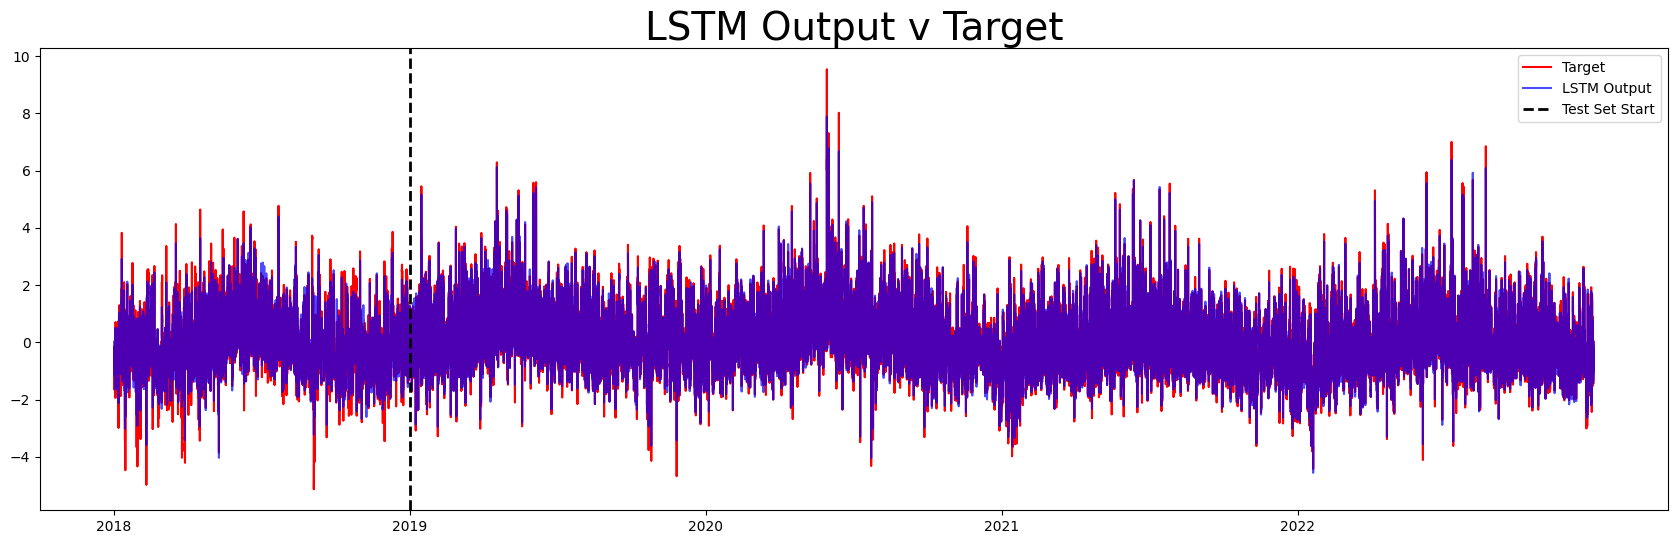

In [50]:
fig, ax = plt.subplots(figsize=(21, 6))
plt.plot(df["target_error_lead_0"], c="r", label="Target")
plt.plot(df["Model forecast"], c="b", alpha=0.7, label="LSTM Output")
plt.axvline(
    x=(int(0.2 * len(df["target_error_lead_0"]))),
    c="black",
    linestyle="--",
    linewidth=2.0,
    label="Test Set Start",
)
ax.set_title("LSTM Output v Target", fontsize=28)
ax.set_xticklabels([2018, 2019, 2020, 2021, 2022])
ax.set_xticks(np.arange(0, len(df["Model forecast"]), (len(df["Model forecast"]) / 5)))
ax.legend()